# Image Text Recognition Model Pipeline

The Pipeline has 2 Functions for Output Prediction:
1. **Single Image Prediction:** Takes a single input Image and Gives the Final Text Label as output
2. **Multiple Image Prediction:** Takes list of Image path names of images to be predicted and prints Actual Text Label and its corresponding Predicted Output Text Label for each Image present in the Folder Path

In [1]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D
from keras.layers import AveragePooling2D, Flatten, Activation, Bidirectional
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from tensorflow.keras.layers import add
from tensorflow.keras.layers import concatenate
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.layers import Reshape
from keras.models import Model
from tensorflow.keras.layers import LSTM, GRU

import tensorflow as tf

2023-06-19 02:05:33.553686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 02:05:49.594751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from IPython.display import Image
import numpy as np
import pandas as pd
import os 
import cv2
from datetime import datetime
import keras
import random
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D,Bidirectional
from keras.layers import AveragePooling2D, Flatten, Activation
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers import add,concatenate
from keras.layers import InputLayer, Activation, Concatenate

from keras.layers import Reshape
from keras.models import Model
from keras.layers import LSTM,GRU
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

### 1. Data Loading

**Sampled_data_100.csv** file contains 100 Images sampled from Synth Text Test Data for Pipeline Implementation

In [3]:
# test_data=pd.read_csv('/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box_ann/Test_Final.csv')
test_data=pd.read_csv('/home/anilroy/khushali_thesis/lstm/dataset/full_data/Test_Final.csv')

In [4]:
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)
print(test_data.shape)

(7614, 2)


In [146]:
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)
print(test_data.shape)

KeyError: "['Unnamed: 0'] not found in axis"

In [ ]:
test_data.head()

In [ ]:
test_data.head()

### 2. Utility Functions

In [5]:
#Letters present in the Label Text
# letters= '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
letters='abcdTRUEFALSoretinysMOVpGklfmguPwhjWx0vBH19583qNDKICYJ7264zZQX'

**Integer Labels to Text Label Converter**

Converts a list of integers to corresponding characters and combines them as a string 

In [6]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
    """
    txt=[]
    for ele in labels:
        if ele == len(letters): # CTC blank space
            txt.append("")
        else:
            #print(letters[ele])
            txt.append(letters[ele])
    return "".join(txt)

**Best Path Decoding**

The Function Takes the final 48x37 output matrix from the model, and takes the argmax of the matrix across each column (which returns a value between 0 to 36 (ctc_blank) both included). The outputs are then merged for repeated values and gives a list of integers. The Final output integers is then converted to final output string text and it is returned by the function

In [7]:
#https://keras.io/examples/image_ocr/
#https://github.com/qjadud1994/CRNN-Keras
def decode_label(out):
    """
    Takes the predicted ouput matrix from the Model and returns the output text for the image
    """
    # out : (1, 48, 37)
    out_best = list(np.argmax(out[0,2:], axis=1))

    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value

    outstr=words_from_labels(out_best)
    return outstr

### 3. Model Parameters

In [8]:
#image height
img_h=32
#image width
img_w=170
#image Channels
img_c=1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(letters)+1
batch_size=32
max_length=15 # considering max length of ground truths labels to be 15

### 4. Model Architecture

In [9]:
def Image_text_recogniser_model_1(drop_out_rate=0.35):


    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)

    model_input = Input(shape=input_shape, name='img_input', dtype='float32')

    # Convolution layer
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model)

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model)

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model = Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model = Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model)

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model = Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    # transforms CNN output to character activations:
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)
    model = Dense(num_classes, kernel_initializer='he_normal', name='dense2')(model)
    y_pred = Activation('softmax', name='softmax')(model)

    labels = Input(name='ground_truth_labels', shape=[max_length], dtype='float32')
    input_length = Input(name='input_length', shape=[1],dtype='int64')
    label_length = Input(name='label_length', shape=[1],dtype='int64')


 
    return Model(inputs=[model_input], outputs=y_pred)

#     if stage == 'train':
#         loss_out = Lambda(ctc_loss_function, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])  # (None, 1)

#         return model_input, y_pred, Model(inputs=[model_input, labels, input_length, label_length], outputs=loss_out)
#     else:  
#         return Model(inputs=[model_input], outputs=y_pred)


In [10]:
# !pip install pydot

from keras.utils.vis_utils import plot_model

model = Image_text_recogniser_model_1()
plot_model(model, to_file='/home/anilroy/khushali_thesis/lstm/dataset/ImageTextRecognition-master/model.png', show_shapes=True)


2023-06-19 02:08:30.728148: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
model = Image_text_recogniser_model_1(drop_out_rate=0.35)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 170, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 170, 32, 64)       640       
                                                                 
 batch_normalization_7 (Batc  (None, 170, 32, 64)      256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 170, 32, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 85, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 85, 16, 128)       73856     
                                                           

In [123]:
def Image_text_recogniser_model_1(drop_out_rate=0.35):
    """
    Builds the model by taking in the stage variable which specifes the stage,
    if the stage is training: model takes inputs required for computing ctc_batch_cost function
    else: model takes input as images which is used for prediction
    """

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)

    model_input = Input(shape=input_shape, name='img_input', dtype='float32')

    # Convolution layer
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model)

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model)

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model = Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model = Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model)

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model = Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)

    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)

    # RNN layer
    model = SimpleRNN(256, return_sequences=True, kernel_initializer='he_normal')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal', name='dense2')(model)
    y_pred = Activation('softmax', name='softmax')(model)
    
#     labels = Input(name='ground_truth_labels', shape=[max_length], dtype='float32')
#     input_length = Input(name='input_length', shape=[1],dtype='int64')
#     label_length = Input(name='label_length', shape=[1],dtype='int64')


#     if stage == 'train':
       
#         # CTC loss function
#         loss_out = Lambda(ctc_loss_function, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])  # (None, 1)

#         return model_input, y_pred, Model(inputs=[model_input, labels, input_length, label_length], outputs=loss_out)
#     else:
    return Model(inputs=[model_input], outputs=y_pred)



In [183]:
def Image_text_recogniser_model_1(drop_out_rate=0.35):
    """
    Builds the model which takes input as images which is used for prediction and returns the Output Matrix 
    of of dimesnions 48x37 where 48 is the number of time-steps of RNN and 37 is the length of letters 
    + 1 character for ctc blank
    """
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
       
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')
    print("aavi gaya")
    # Convolution layer 
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)
    print("ahiya bhi")

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)
    print("nikdi gaya")

    return Model(inputs=[model_input], outputs=y_pred)

In [220]:
def create_model_2(drop_out_rate=0.35):
    """
    Builds the model by taking in the stage variable which specifes the stage,
    if the stage is training: model takes inputs required for computing ctc_batch_cost function
    else : model takes input as images which is used for prediction
    """
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
       
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    # Convolution layer 
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)  

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
#     print(model.shape)
    

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    # RNN layer
    model=Bidirectional(GRU(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(GRU(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)

    return Model(inputs=[model_input], outputs=y_pred)

#     labels = Input(name='ground_truth_labels', shape=[max_length], dtype='float32') 
#     input_length = Input(name='input_length', shape=[1], dtype='int64') 
#     label_length = Input(name='label_length', shape=[1], dtype='int64') 

#     #CTC loss function
#     loss_out = Lambda(ctc_loss_function, output_shape=(1,),name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

#     if stage=='train':
#         return model_input,y_pred,Model(inputs=[model_input, labels, input_length, label_length], outputs=loss_out)
#     else:
#         return Model(inputs=[model_input], outputs=y_pred)        

In [152]:
def Image_text_recogniser_model_1(drop_out_rate=0.35):
    """
    Builds the model by taking in the stage variable which specifes the stage,
    if the stage is training: model takes inputs required for computing ctc_batch_cost function
    else : model takes input as images which is used for prediction
    """
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
        print(input_shape)
    else:
        input_shape = (img_w, img_h, 1)
        print(input_shape)
       
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')
    print(model_input)

    # Convolution layer 
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)  

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)  
    # CNN to RNN
#     model = Reshape(target_shape=((3*24, 512)), name='reshape')(model)  

    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    # RNN layer
    model = LSTM(256, return_sequences=True, kernel_initializer='he_normal')(model)
    model = LSTM(256, return_sequences=True, kernel_initializer='he_normal')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)

    
    labels = Input(name='ground_truth_labels', shape=[max_length], dtype='float32') 
    input_length = Input(name='input_length', shape=[1], dtype='int64') 
    label_length = Input(name='label_length', shape=[1], dtype='int64') 

    #CTC loss function
#     loss_out = Lambda(ctc_loss_function, output_shape=(1,),name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    return Model(inputs=[model_input], outputs=y_pred)     


### 5. Image Prediction Pipeline

In [12]:
def test_data_single_image_Prediction(model,test_img_path):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
    generate predicted text and prints the Predicted Text Label, Time Taken for Computation
    """
    start=datetime.now()
    
    test_img=cv2.imread(test_img_path)
    test_img_resized=cv2.resize(test_img,(170,32))
    test_image=test_img_resized[:,:,1]
    test_image=test_image.T 
    test_image=np.expand_dims(test_image,axis=-1)
    test_image=np.expand_dims(test_image, axis=0)
    test_image=test_image/255
    model_output=model.predict(test_image)
    predicted_output=decode_label(model_output)
    print("Predicted Text in the Image: ", predicted_output)
    print("Time Taken for Processing: ",datetime.now()-start)    

In [154]:
def test_data_multiple_image_Prediction(model,test_img_names,test_labels,total):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
    generate predicted text and compares with ground truth text for the input and ouputs the final accuracy,
    letter accuracy and  letter count across the entire test set of images
    """
    start=datetime.now()
    accuracy=0
    letter_acc=0
    letter_cnt=0
    count=0
    for i in range(len(test_labels)):
        test_img=cv2.imread(test_img_names[i])
        test_img_resized=cv2.resize(test_img,(170,32))
        test_image=test_img_resized[:,:,1]
        test_image=test_image.T
        test_image=np.expand_dims(test_image,axis=-1)
        test_image=np.expand_dims(test_image, axis=0)
        test_image=test_image/255
        model_output=model.predict(test_image)
        predicted_output=decode_label(model_output)
        actual_output=test_labels[i]
        count+=1
        for j in range(min(len(predicted_output),len(actual_output))):
            if predicted_output[j]==actual_output[j]:
                letter_acc+=1
        letter_cnt+=max(len(predicted_output),len(actual_output))
        if actual_output==predicted_output:
            accuracy+=1
        print("-"*80)
        print("Actual Text: ",actual_output,"   Predicted Text: ",predicted_output)
    print("="*80)
    print(accuracy)
    print("Model Output Accuracy: ",(accuracy/1112)*100, " %")
    print("Model Output Letter Accuracy: ",(letter_acc/letter_cnt)*100, " %")
    print("Time Taken for Processing: ",datetime.now()-start)

In [ ]:
# import cv2
# import itertools
# import numpy as np
# from datetime import datetime

# # # Define the model, letters, and beam width
# # model = # your model
# # letters = # your letters
# beam_width = 3

def decode_label(val):
    text = ""
    for s in val:
        if s>64:
            text+='#'
        else:
            if s != 0:
                print(s)
                text += letters[s-1]
    return text


# def words_from_labels(labels):
#     """
#     converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
#     """
#     txt=[]
#     for ele in labels:
#         if ele == len(letters): # CTC blank space
#             txt.append("")
#         else:
#             #print(letters[ele])
#             txt.append(letters[ele])
#     return "".join(txt)

def beam_search_decoder(data, k):
    sequences = [[list(), 0.0]]
    # the beam search algorithm
    for row in data[0]:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - np.log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

# def test_data_single_image_Prediction(model, test_img_path):
#     """
#     Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
#     appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
#     generate predicted text and prints the Predicted Text Label, Time Taken for Computation
#     """
#     start=datetime.now()
    
#     test_img=cv2.imread(test_img_path)
#     test_img_resized=cv2.resize(test_img,(170,32))
#     test_image=test_img_resized[:,:,1]
#     test_image=test_image.T 
#     test_image=np.expand_dims(test_image,axis=-1)
#     test_image=np.expand_dims(test_image, axis=0)
#     test_image=test_image/255
#     model_output=model.predict(test_image)
#     print(model_output)
# #     output=decode_label(model_output)
# #     print(output)
#     sequences = beam_search_decoder(model_output, beam_width)
# #     print(sequences)
#     predicted_output = ''
#     for seq in sequences:
#         print(seq)
#         output = decode_label(np.squeeze(seq[0]))
#         predicted_output += output
#         print("Predicted Text in the Image: ", predicted_output)
#     print("Time Taken for Processing: ",datetime.now()-start)    


In [ ]:
def test_data_single_image_Prediction(model, test_img_path, beam_width):
    """
    Takes the best model, test data image paths, test data ground truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses beam search decoding to 
    generate predicted text and prints the Predicted Text Label, Time Taken for Computation
    """
    start = datetime.now()
    
    test_img = cv2.imread(test_img_path)
    test_img_resized = cv2.resize(test_img, (170, 32))
    test_image = test_img_resized[:, :, 1]
    test_image = test_image.T 
    test_image = np.expand_dims(test_image, axis=-1)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image / 255
    model_output = model.predict(test_image)
    
    sequences = beam_search_decoder(model_output, beam_width)
    predicted_output = decode_label(np.array(sequences[0][0]))
    
    print("Predicted Text in the Image: ", predicted_output)
    print("Time Taken for Processing: ", datetime.now()-start)


In [ ]:
test_data_single_image_Prediction(model,test_image_1,10)

In [ ]:
def beam_search_decoder(data, k, end_token):
    sequences = [[list(), 0.0]]
    # the beam search algorithm
    for row in data[0]:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - np.log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        # select k best
        sequences = ordered[:k]
        # check if any sequences have reached maximum length or if end token is predicted
        for seq in sequences:
            if len(seq[0]) == 15 or seq[0][-1] == end_token:
                seq[0].append(end_token)
    return sequences
def test_data_single_image_Prediction(model, test_img_path, beam_width):
    """
    Takes the best model, test data image paths, test data ground truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses beam search decoding to 
    generate predicted text and prints the Predicted Text Label, Time Taken for Computation
    """
    start = datetime.now()
    
    test_img = cv2.imread(test_img_path)
    test_img_resized = cv2.resize(test_img, (170, 32))
    test_image = test_img_resized[:, :, 1]
    test_image = test_image.T 
    test_image = np.expand_dims(test_image, axis=-1)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image / 255
    model_output = model.predict(test_image)
    
    beam_width = 10
    end_token=65
    beam_decoded = beam_search_decoder(model_output, beam_width, end_token)
    predicted_output = decode_label(beam_decoded[0][0][:-1])  # remove end token from sequence
    print("Predicted Text in the Image: ", predicted_output)

In [ ]:
test_data_single_image_Prediction(model,test_image_1,10)

### 6. Loading Best Model 

In [222]:
# train your model here
# sess = K.get_session()
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# sess.close()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# model = model_create(drop_out_rate=0.35)
model = create_model_2(drop_out_rate=0.35)

2023-06-19 03:53:47.752280: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6642069377880436268
xla_global_id: -1
]


2023-06-19 03:53:48.250097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 03:53:48.252367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 03:53:48.253579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [63]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 170, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 170, 32, 64)       640       
                                                                 
 batch_normalization_21 (Bat  (None, 170, 32, 64)      256       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 170, 32, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 85, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 85, 16, 128)       73856     
                                                           

The Best Weights for the Model are stored in BestLSTMModelWeights Folder, loading the stored best weights for Model 1 for prediction

In [219]:
model = create_model_2(drop_out_rate=0.35)
model.summary()

2023-05-21 17:07:11.999975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 17:07:12.001941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 17:07:12.003151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 170, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 170, 32, 64)       640       
                                                                 
 batch_normalization_84 (Bat  (None, 170, 32, 64)      256       
 chNormalization)                                                
                                                                 
 activation_84 (Activation)  (None, 170, 32, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 85, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 85, 16, 128)       73856     
                                                          

In [221]:
# Image_text_recogniser_model_1
model = Image_text_recogniser_model_1(drop_out_rate=0.35)
# model.summary()

aavi gaya
ahiya bhi


2023-06-19 03:52:46.007624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 03:52:46.009454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 03:52:46.010725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

nikdi gaya


In [223]:
# model.load_weights('Best_Img_recog_LSTM_Adam_model_run_weights.h5')
# model.load_weights('/home/anilroy/khushali_thesis/lstm/dataset/ImageTextRecognition-master/Best_Img_recog_CNN_Adam_model_run_weights.h5')
# model.load_weights('Best_Img_recog_LSTM_Adam_model_run_weights1f.h5')
model.load_weights('Best_Img_recog_GRU_RAdam_model_run_weightsm22.h5')
# model.load_weights('/home/anilroy/khushali_thesis/lstm/dataset/ImageTextRecognition-master/Best_Img_recog_RNN_Adam_model_run_weights31.h5')

### 7. Single Image Prediction

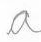

In [224]:
test_image_1='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box601.png'
Image(test_image_1)

In [225]:
test_data_single_image_Prediction(model,test_image_1)

2023-06-19 03:54:15.880052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 03:54:15.882219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 03:54:15.884046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step
Predicted Text in the Image:  a
Time Taken for Processing:  0:00:01.916357


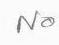

In [226]:
test_image_1='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box852.png'
Image(test_image_1)

In [227]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 80ms/step
Predicted Text in the Image:  no
Time Taken for Processing:  0:00:00.142844


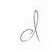

In [228]:
test_image_1='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box665.png'
Image(test_image_1)

In [229]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 63ms/step
Predicted Text in the Image:  d
Time Taken for Processing:  0:00:00.126355


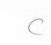

In [230]:
test_image_1='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box660.png'
Image(test_image_1)

In [231]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 59ms/step
Predicted Text in the Image:  c
Time Taken for Processing:  0:00:00.126889


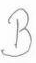

In [232]:
test_image_1='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box606.png'
Image(test_image_1)

In [233]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 62ms/step
Predicted Text in the Image:  b
Time Taken for Processing:  0:00:00.118950


In [234]:
test_image_1='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box740.png'

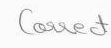

In [235]:
Image(test_image_1)

In [236]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 85ms/step
Predicted Text in the Image:  correct
Time Taken for Processing:  0:00:00.137029


In [237]:
test_image_1='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box645.png'

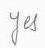

In [238]:
Image(test_image_1)

In [239]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 52ms/step
Predicted Text in the Image:  yes
Time Taken for Processing:  0:00:00.094857


In [240]:
test_image_1='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box689.png'

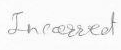

In [241]:
Image(test_image_1)

In [242]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 56ms/step
Predicted Text in the Image:  incorrect
Time Taken for Processing:  0:00:00.109292


In [243]:
test_image_2='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box630.png'
# '/home/anilroy/khushali_thesis/lstm/imd.jpg'
# /home/anilroy/khushali_thesis/lstm/imd.jpg
#/home/anilroy/khushali_thesis/lstm/cut4.jpeg

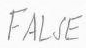

In [244]:
Image(test_image_2)

In [245]:
test_data_single_image_Prediction(model,test_image_2)
# /home/anilroy/khushali_thesis/lstm/dataset/dataset_code/test_images/d01-049-02-04.png
# /home/anilroy/khushali_thesis/lstm/dataset/dataset_code/test_images/d01-049-01-08.png
# /home/anilroy/khushali_thesis/lstm/dataset/dataset_code/test_images/d04-008-05-05.png

1/1 [==============================] - 0s 59ms/step
Predicted Text in the Image:  TRUE
Time Taken for Processing:  0:00:00.128647


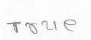

In [246]:
test_image_3='/home/anilroy/khushali_thesis/lstm/dataset/tensorflow_dataset/test_box/box880.png'
Image(test_image_3)

In [247]:

test_data_single_image_Prediction(model,test_image_3)

1/1 [==============================] - 0s 57ms/step
Predicted Text in the Image:  TRUE
Time Taken for Processing:  0:00:00.122305


In [214]:
test_image_3='/home/anilroy/khushali_thesis/lstm/dataset/dataset_code/test_images/d04-008-05-05.png'
test_image_4='/home/anilroy/khushali_thesis/lstm/dataset/dataset_code/test_images/d06-050-03-01.png'

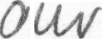

In [215]:
Image(test_image_4)

In [216]:
test_data_single_image_Prediction(model,test_image_4)

1/1 [==============================] - 0s 62ms/step
Predicted Text in the Image:  ow
Time Taken for Processing:  0:00:00.122185


### 8. Multiple Image Prediction

In [17]:
test_img_paths=test_data['images_path'].values
test_img_labels=test_data['label'].values
total=100

In [30]:
# bilstm
test_data_multiple_image_Prediction(model,test_img_paths,test_img_labels,total)

2023-04-19 01:26:23.368868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 01:26:23.384424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 01:26:23.386375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 4s 4s/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 110ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 105ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 147ms/step
--------------------------------------------------------------------------------
Actual Tex

1/1 [==============================] - 0s 133ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 112ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  b
1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 96ms/step
-----------------------------------------------------------------------------

1/1 [==============================] - 0s 150ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 96ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 152ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yeo
1/1 [==============================] - 0s 118ms/step
---------------------------------------------------------

1/1 [==============================] - 0s 121ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 141ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 110ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  ncorrect
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 115ms/step
---------------------

1/1 [==============================] - 0s 50ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 132ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 63ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 110ms/step
-------------------------------

1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correect
1/1 [==============================] - 0s 108ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 78ms/step
------------------------------

1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 123ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 98ms/step
--------------------------------------------

1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 106ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 114ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSnr
1/1 [==============================] - 0s 116ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 110ms/step
----------------------------------------------------

1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 69ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------

1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 101ms/step
-------------------------------------------------------------------------

--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 101ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSEo
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSno
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Pr

1/1 [==============================] - 0s 113ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 98ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 124ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 89ms/step
-------------------------------------------------------------------

1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  a
1/1 [==============================] - 0s 130ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Act

1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 119ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Te

1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 101ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  d
1/1 [==============================] - 0s 124ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 96ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 58ms/step
--------------------------------------------------------------------------------
Actual Tex

1/1 [==============================] - 0s 105ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  b
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 65ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  d
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Tex

1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  es
1/1 [==============================] - 0s 65ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  b
1/1 [==============================] - 0s 114ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  d
1/1 [==============================] - 0s 101ms/step
--------------------------------------------------------------------------------
Actual

1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 117ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------

1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 72ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 93ms/step
---------------------------------------------------------

1/1 [==============================] - 0s 101ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 98ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corrrect
1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  ccorrect
1/1 [==============================] - 0s 127ms/step
---------------------

1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 105ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 140ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 112ms/step
------------------

1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  TALUE
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 127ms/step
----------------------------------

1/1 [==============================] - 0s 123ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 108ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 160ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 114ms/step
---------------------------------------------------------

1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 56ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 57ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 93ms/step
---------------------------------------------------------------------

In [33]:
# lstm
test_data_multiple_image_Prediction(model,test_img_paths,test_img_labels,total)

2023-04-17 03:58:52.627957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 03:58:52.646174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 03:58:52.647610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 4s 4s/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  b
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  b
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  b
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  b
1/1 [==============================] - 0s 108ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  b
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:

1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  bes
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  bes
1/1 [==============================] - 0s 117ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  bo
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  bs
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  bo
1/1 [==============================] - 0s 74ms/step
------------------------------------------------------------------------------

1/1 [==============================] - 0s 47ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  bes
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  bes
1/1 [==============================] - 0s 44ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  bes
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 89ms/step
-------------------------------------------------------------

1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorocet
1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  ncorreect
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 89ms/step
------------------------

1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 93ms/step
---------------------------------

1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 57ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  inrrect
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 106ms/step
--------------------------------

1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  Forrect
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  crrect
1/1 [==============================] - 0s 93ms/step
--------------------------------------------

1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  bRUE
1/1 [==============================] - 0s 62ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  TALSE
1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FoLSE
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 101ms/step
--------------------------------------------------------

1/1 [==============================] - 0s 98ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 117ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 112ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  bRUE
1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  aALSE
1/1 [==============================] - 0s 110ms/step
-------------------------------------------------------

1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  a
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  a
1/1 [==============================] - 0s 127ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  FRUE
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  aRUE
1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 97ms/step
-------------------------------------------------------------------------

--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  nRUE
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 109ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 65ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Pred

1/1 [==============================] - 0s 52ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  b
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------

1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  T
1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  ae
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  b
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  T
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actua

1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  b
1/1 [==============================] - 0s 41ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  b
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  b
1/1 [==============================] - 0s 39ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  b
1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  b
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:

1/1 [==============================] - 0s 114ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  b
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  b
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  b
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  c
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  b
1/1 [==============================] - 0s 62ms/step
--------------------------------------------------------------------------------
Actual Text

1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  b
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  b
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  b
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  b
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  b
1/1 [==============================] - 0s 101ms/step
--------------------------------------------------------------------------------
Actual Te

1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  b
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  b
1/1 [==============================] - 0s 115ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  b
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual 

1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 45ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  aes
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 127ms/step
--------------------------------------------------------------------------

1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  aes
1/1 [==============================] - 0s 73ms/step
---------------------------------------------------------

1/1 [==============================] - 0s 108ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  crrect
1/1 [==============================] - 0s 109ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 105ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 83ms/step
-----------------------

1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 84ms/step
---------------------

1/1 [==============================] - 0s 109ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  TALSE
1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  norrect
1/1 [==============================] - 0s 43ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 106ms/step
----------------------------------

1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 47ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TUE
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  yRUE
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  yALSE
1/1 [==============================] - 0s 101ms/step
-------------------------------------------------------------

1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  b
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  yRUE
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  yRUE
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  bRUE
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  yRUE
1/1 [==============================] - 0s 47ms/step
---------------------------------------------------------------------

In [22]:
# cnn
test_data_multiple_image_Prediction(model,test_img_paths,test_img_labels,total)

1/1 [==============================] - 0s 436ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 56ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 42ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Text

1/1 [==============================] - 0s 39ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 98ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  Rno
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  nRc
1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  RnUE
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------

1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 54ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 67ms/step
-------------------------------------------------------------

1/1 [==============================] - 0s 69ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorocect
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  ircorrct
1/1 [==============================] - 0s 69ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  iowcoeRecy
1/1 [==============================] - 0s 105ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yEes
1/1 [==============================] - 0s 69ms/step
----------------------

1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  coect
1/1 [==============================] - 0s 43ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  conect
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corect
1/1 [==============================] - 0s 96ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  conect
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  coect
1/1 [==============================] - 0s 56ms/step
----------------------------------------

1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correcE
1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corRect
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  coRrAct
1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corRcT
1/1 [==============================] - 0s 96ms/step
----------------------------------

1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 69ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  ccrrect
1/1 [==============================] - 0s 64ms/step
---------------------------------------------

1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 72ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  cALSE
1/1 [==============================] - 0s 52ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 36ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 53ms/step
---------------------------------------------------------

1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 121ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRAUE
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 83ms/step
---------------------------------------------------------

1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 46ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  cd
1/1 [==============================] - 0s 64ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 69ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  cTRUE
1/1 [==============================] - 0s 49ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 74ms/step
-------------------------------------------------------------------------

1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 60ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALUE
1/1 [==============================] - 0s 121ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSc
1/1 [==============================] - 0s 74ms/step
------------------------------------------------------

1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUc
1/1 [==============================] - 0s 62ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 55ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 60ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUc
1/1 [==============================] - 0s 72ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 67ms/step
---------------------------------------------------------------

1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  e
1/1 [==============================] - 0s 109ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  c
1/1 [==============================] - 0s 106ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  e
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TUe
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TeUE
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------

1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 69ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 48ms/step
--------------------------------------------------------------------------------
Actual Text:

1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  d
1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  E
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 44ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 65ms/step
--------------------------------------------------------------------------------
Actual Text:

1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  ao
1/1 [==============================] - 0s 69ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 49ms/step
--------------------------------------------------------------------------------
Actual Text

1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 32ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 206ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text

1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 63ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------

1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corret
1/1 [==============================] - 0s 66ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 53ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yEo
1/1 [==============================] - 0s 64ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yec
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yos
1/1 [==============================] - 0s 77ms/step
------------------------------------------------------------------

1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incornecE
1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  coRrecct
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  coRrect
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 60ms/step
------------------------------------

1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 72ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corrnect
1/1 [==============================] - 0s 69ms/step
------------------------

1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 43ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correcT
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corrcct
1/1 [==============================] - 0s 74ms/step
--------------------------------

1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  aUE
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUUE
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 119ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  TALSE
1/1 [==============================] - 0s 56ms/step
----------------------------------------------------------

1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRE
1/1 [==============================] - 0s 65ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TUE
1/1 [==============================] - 0s 71ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  RUE
1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TUE
1/1 [==============================] - 0s 83ms/step
-------------------------------------------------------------------

In [18]:
# rnn
test_data_multiple_image_Prediction(model,test_img_paths,test_img_labels,total)

1/1 [==============================] - 1s 1s/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  GpiA
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  GpiA
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  GpiA
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  GpiA
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  GpiA
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------

1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GpiA
1/1 [==============================] - 0s 110ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GpiA
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GpiA
1/1 [==============================] - 0s 103ms/step
---------------------------------------------------------------------

1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GpiA
1/1 [==============================] - 0s 113ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 64ms/step
-------------------------------------------------------------

1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GiG1GiGiGpip
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GpiA
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GpiA
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GpiAiAiGip
1/1 [==============================] - 0s 113ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GiziGiGiGiGiA
1/1 [==============================] - 0s 81ms/step
--------------

1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 96ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  GpiA
1/1 [==============================] - 0s 112ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  GpziziA
1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  GpGiA
1/1 [==============================] - 0s 85ms/step
-----------------------------------------------

--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 47ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predic

1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 98ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 62ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GiA
1/1 [==============================] - 0s 101ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 97ms/step
-----------------------------------------------------------

1/1 [==============================] - 0s 71ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  GpiA
1/1 [==============================] - 0s 109ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  GpiA
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 155ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 85ms/step
-------------------------------------------------------------------

1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  GpiA
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  GpiA
1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 74ms/step
---------------------------------------------------------------------

1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 98ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 55ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 62ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 70ms/step
------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GipiziA
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GiA
1/1 [==============================] - 0s 104ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GipiA
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GiA
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  Gpipi1iA
1/1 [==============================] - 0s 48ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  GpiA
1

1/1 [==============================] - 0s 56ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  GiA
1/1 [==============================] - 0s 40ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  GpiA
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  GiA
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  GpiA
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  GpiA
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------

1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GiA
1/1 [==============================] - 0s 108ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GpiA
1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  GpiA
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  GpiA
1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 88ms/step
---------------------------------------------------------------------------

1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GpiA
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 62ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GpiA
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GpiA
1/1 [==============================] - 0s 83ms/step
----------------------------------------------------------------------

1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GpiA
1/1 [==============================] - 0s 65ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 66ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  GpiA
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  GpiA
1/1 [==============================] - 0s 72ms/step
----------------------------------------------------------------------

1/1 [==============================] - 0s 64ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  GpiA
1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GpGiziA
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GpiA
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GpiziziA
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GpiA
1/1 [==============================] - 0s 68ms/step
---------------------------------

1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  GiziA
1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GiA
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  Gip
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  Gpzip
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GiA
1/1 [==============================] - 0s 80ms/step
-------------------------------------------

1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  GiA
1/1 [==============================] - 0s 61ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  GpiA
1/1 [==============================] - 0s 71ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  GiA
1/1 [==============================] - 0s 108ms/step
----------------------------------------------------

1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GiA
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GpiA
1/1 [==============================] - 0s 98ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  GiA
1/1 [==============================] - 0s 55ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  GpiA
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------

1/1 [==============================] - 0s 65ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 54ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  GpiA
1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  GpiA
1/1 [==============================] - 0s 56ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  GpiA
1/1 [==============================] - 0s 83ms/step
------------------------------------------------------------------------------

1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 53ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  GpiA
1/1 [==============================] - 0s 94ms/step
------------------------------------------------------------------------------

In [26]:
# RNN
test_data_multiple_image_Prediction(model,test_img_paths,test_img_labels,total)

1/1 [==============================] - 0s 350ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  c
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  c
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Tex

1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  Tes
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  nE
1/1 [==============================] - 0s 112ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  TR
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  nE
1/1 [==============================] - 0s 117ms/step
----------------------------------------------------------------------------

1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 61ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 62ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 109ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 72ms/step
------------------------------------------------------------

1/1 [==============================] - 0s 118ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorvcect
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrprect
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrct
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  sveorceecs
1/1 [==============================] - 0s 66ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yES
1/1 [==============================] - 0s 57ms/step
---------------------

1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 126ms/step
--------------------------------

1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correcE
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 71ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  iccrrect
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corrcTt
1/1 [==============================] - 0s 95ms/step
-------------------------------

1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 33ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 66ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  ccrrEct
1/1 [==============================] - 0s 34ms/step
---------------------------------------------

1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FARLSE
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  cLSE
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  eLSE
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TReUE
1/1 [==============================] - 0s 92ms/step
---------------------------------------------------------

1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TReUE
1/1 [==============================] - 0s 57ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 66ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 63ms/step
----------------------------------------------------------

1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  
1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  
1/1 [==============================] - 0s 63ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  cUUUE
1/1 [==============================] - 0s 60ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  cRUE
1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  LE
1/1 [==============================] - 0s 70ms/step
------------------------------------------------------------------------------

1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  cLEE
1/1 [==============================] - 0s 113ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  aLcE
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  ALrE
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  TFALSE
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------

1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 113ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 134ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TUE
1/1 [==============================] - 0s 51ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------

1/1 [==============================] - 0s 72ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  yb
1/1 [==============================] - 0s 66ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  
1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUUe
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  ReUE
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------

1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  d
1/1 [==============================] - 0s 98ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:

1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  L
1/1 [==============================] - 0s 116ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 116ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  
1/1 [==============================] - 0s 125ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text

1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 96ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 101ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  d
1/1 [==============================] - 0s 105ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 117ms/step
--------------------------------------------------------------------------------
Actual Te

1/1 [==============================] - 0s 47ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 67ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 119ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  
1/1 [==============================] - 0s 69ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text

1/1 [==============================] - 0s 112ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  nd
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 115ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 77ms/step
-------------------------------------------------------------------------

1/1 [==============================] - 0s 73ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corret
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yES
1/1 [==============================] - 0s 138ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yEs
1/1 [==============================] - 0s 129ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  eE
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yES
1/1 [==============================] - 0s 84ms/step
----------------------------------------------------------------

1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correcct
1/1 [==============================] - 0s 63ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  ccrrect
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 58ms/step
-----------------------------------

1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  cornect
1/1 [==============================] - 0s 110ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  inccrrrect
1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 60ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 79ms/step
----------------------

1/1 [==============================] - 0s 71ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  Lcorrect
1/1 [==============================] - 0s 108ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corcrect
1/1 [==============================] - 0s 54ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 116ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corretE
1/1 [==============================] - 0s 114ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 116ms/step
---------------------------

1/1 [==============================] - 0s 39ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  yRUE
1/1 [==============================] - 0s 75ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 62ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  ALE
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FRLE
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------

1/1 [==============================] - 0s 64ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRE
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRE
1/1 [==============================] - 0s 134ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  aRUE
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  yRE
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  dcE
1/1 [==============================] - 0s 68ms/step
------------------------------------------------------------------

In [34]:
# gru
test_data_multiple_image_Prediction(model,test_img_paths,test_img_labels,total)

2023-04-19 01:33:52.063848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 01:33:52.066960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 01:33:52.083651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 141ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 105ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:

1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 103ms/step
------------------------------------------------------------------------------

1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 107ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  es
1/1 [==============================] - 0s 137ms/step
-----------------------------------------------------------

1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incncorrect
1/1 [==============================] - 0s 47ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  woprert
1/1 [==============================] - 0s 109ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 99ms/step
-----------------------

1/1 [==============================] - 0s 105ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 121ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 103ms/step
------------------------------

1/1 [==============================] - 0s 63ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  corect
1/1 [==============================] - 0s 124ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 106ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  coorrect
1/1 [==============================] - 0s 106ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 116ms/step
----------------------------

1/1 [==============================] - 0s 96ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 143ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 117ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 130ms/step
------------------------------------------

1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 74ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 106ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 85ms/step
--------------------------------------------------------

1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 106ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 137ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 110ms/step
-------------------------------------------------------

1/1 [==============================] - 0s 65ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 159ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 134ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 101ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 52ms/step
------------------------------------------------------------------------

1/1 [==============================] - 0s 61ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALUE
1/1 [==============================] - 0s 88ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 98ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 90ms/step
-------------------------------------------------------

1/1 [==============================] - 0s 126ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 134ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 99ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 109ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 94ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 119ms/step
-----------------------------------------------------------

1/1 [==============================] - 0s 136ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  c
1/1 [==============================] - 0s 86ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 70ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 73ms/step
-------------------------------------------------------------------------------

1/1 [==============================] - 0s 119ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 125ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 126ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 108ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 146ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 120ms/step
--------------------------------------------------------------------------------
Actual

1/1 [==============================] - 0s 103ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  b
1/1 [==============================] - 0s 142ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 110ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 162ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 131ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 120ms/step
--------------------------------------------------------------------------------
Actual

1/1 [==============================] - 0s 136ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  a
1/1 [==============================] - 0s 63ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 97ms/step
--------------------------------------------------------------------------------
Actual Text:  c    Predicted Text:  c
1/1 [==============================] - 0s 90ms/step
--------------------------------------------------------------------------------
Actual Text:  b    Predicted Text:  b
1/1 [==============================] - 0s 95ms/step
--------------------------------------------------------------------------------
Actual Text:  d    Predicted Text:  d
1/1 [==============================] - 0s 115ms/step
--------------------------------------------------------------------------------
Actual Tex

1/1 [==============================] - 0s 61ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 71ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 78ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 46ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 57ms/step
--------------------------------------------------------------------------------
Actual Text:  a    Predicted Text:  a
1/1 [==============================] - 0s 54ms/step
--------------------------------------------------------------------------------
Actual Text:

1/1 [==============================] - 0s 130ms/step
--------------------------------------------------------------------------------
Actual Text:  no    Predicted Text:  no
1/1 [==============================] - 0s 91ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 76ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 106ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 117ms/step
------------------------------------------------------------------------

1/1 [==============================] - 0s 114ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 92ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 82ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 116ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 118ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 123ms/step
-------------------------------------------------------------

1/1 [==============================] - 0s 54ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 89ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 119ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 60ms/step
--------------------------------------------------------------------------------
Actual Text:  yes    Predicted Text:  yes
1/1 [==============================] - 0s 113ms/step
-----------------------------------

1/1 [==============================] - 0s 77ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 87ms/step
--------------------------------------------------------------------------------
Actual Text:  incorrect    Predicted Text:  incorrect
1/1 [==============================] - 0s 83ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 81ms/step
------------------------

1/1 [==============================] - 0s 115ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 43ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 64ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 120ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 115ms/step
--------------------------------------------------------------------------------
Actual Text:  correct    Predicted Text:  correct
1/1 [==============================] - 0s 95ms/step
------------------------------

1/1 [==============================] - 0s 80ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 93ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 137ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 102ms/step
--------------------------------------------------------------------------------
Actual Text:  FALSE    Predicted Text:  FALSE
1/1 [==============================] - 0s 124ms/step
-------------------------------------------------------

1/1 [==============================] - 0s 64ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 135ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 134ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 81ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  TRUE    Predicted Text:  TRUE
1/1 [==============================] - 0s 102ms/step
------------------------------------------------------------

In [ ]:
test_img_paths=test_data['images_path'].values
test_img_labels=test_data['label'].values
total=100
test_data_multiple_image_Prediction(model,test_img_paths,test_img_labels,total)